# Save representative MD conformations to `pdb` for ensemble docking

In [1]:
import pytraj as pyt
import pandas as pd
import sys, os
from pathlib import Path
sys.path.append('../..')

### Reference structure
- Used to load each conformation to perform the alignment before save them to a file.

In [2]:
CRYS_DIR = '../../data/crystal_confs/'
ref_top_path = f'{CRYS_DIR}/pdb_ensemble/1fin_ENS.pdb'
ref_conf = pyt.load(ref_top_path, 
                    ref_top_path)
ref_conf

pytraj.Trajectory, 1 frames: 
Size: 0.000108 (GB)
<Topology: 4848 atoms, 298 residues, 1 mols, non-PBC>
           

### Pocket mask to align the MD structures

In [3]:
from helper_modules.protein_subsequences import get_pocket_residues
# Create the atom selection masks
mask_pkt_Ca   = '(:' + get_pocket_residues(sep = ',') + ')&(@CA)'
mask_pkt_noHs = '(:' + get_pocket_residues(sep = ',') + ')&!(@H=)'

### DataFrame with the medoids

In [4]:
# Load the dataframe with the selected conformations
proj_type = 'MDconfsOnMDconfs'
selection_mask = 'Pocket'
df_med = pd.read_pickle(f'kMedoid_{proj_type}_{selection_mask}Selection')
traj_groups = df_med.groupby(['Conf.', 'MD-Protocol', 'Rep.'])
traj_keys = list(traj_groups.groups.keys())
df_med

,Conf.,MD-Protocol,Rep.,frame_number,1,2,3,4,5,6,k_label
0,1fin,ETA,1,1425,-4.747062,9.476703,15.828750,-0.922845,-6.076183,-3.477493,26.0
1,1fin,ETA,1,1970,-8.054590,0.984570,11.983848,1.957229,-2.955415,0.831741,5.0
2,1fin,ETA,1,2050,-6.509101,1.551004,22.635493,6.427479,-9.259333,1.941670,19.0
3,1fin,ETA,1,2130,5.695322,10.208460,26.758872,5.949974,-3.390013,4.882032,29.0
4,1fin,ETA,1,2195,-13.427571,1.947794,2.758341,1.271695,0.594524,-2.758848,12.0
...,...,...,...,...,...,...,...,...,...,...,...
595,4fku,WAT,3,2210,4.127889,9.823015,2.581585,-7.052555,14.663718,3.987882,2.0
596,4fku,WAT,3,2315,1.406441,14.757703,-2.017722,-5.279552,10.958504,5.736013,26.0
597,4fku,WAT,3,3105,-8.925176,5.990160,6.107797,-5.796190,7.052180,-6.708598,10.0
598,4fku,WAT,3,3590,-5.329648,15.114928,1.211712,-1.469104,8.236850,0.713738,4.0


### Write medoid MD confs to `PDB` format

In [5]:
import subprocess

# Define input and output folders
OUTPUT_DIR = f'../../data/md_medoid_conformations/{proj_type}'
Path(OUTPUT_DIR).mkdir(exist_ok=True, parents=True)
MD_DIR  = '../../data/md_trajectories/'
MD_FILE_BASENAME = 'md_imaged_noWAT'

# Create the subdirectories
for system in df_med['MD-Protocol'].unique():
    Path(f'{OUTPUT_DIR}/raw_confs/{system}')\
        .mkdir(exist_ok=True, parents=True)
    Path(f'{OUTPUT_DIR}/ens_confs/{system}')\
        .mkdir(exist_ok=True, parents=True)

    
DONE = True 
for traj_key in traj_keys:
    if DONE:
        break
    # Get the frames of the current rep
    frames   = traj_groups.get_group(traj_key)['frame_number'].to_list()
    pdbid, system, rep = traj_key
    pdb_top_path    = f'{MD_DIR}/{system}_systems/rep_{rep}/' +\
                      f'{pdbid}/md/{MD_FILE_BASENAME}.pdb'
    pdbid_traj_path = f'{MD_DIR}/{system}_systems/rep_{rep}/' + \
                      f'{pdbid}/md/{MD_FILE_BASENAME}.trr'
    # Load the trajectory
    traj = pyt.load(pdbid_traj_path, 
                    top = pdb_top_path,
                    frame_indices = frames)
    if system == 'LIG':
        traj = traj['!:LIG'] # Remove `:LIG` residue, if present
    # Align the traj to the reference structure
    traj = pyt.align(traj, ref = ref_conf)
    for i, frame in enumerate(frames):
        # Create the output name
        output_file_RAW = f'{OUTPUT_DIR}/raw_confs/{system}/' + \
                           f'{pdbid}-{system}-rep{rep}-frame{frame}.pdb'
        # Save the pdb file without hydrogens
        pyt.write_traj(filename  = output_file_RAW, 
                       overwrite = True,
                       traj = traj[i:i+1])

## Visualize the saved structures

In [6]:
saved_frames = list(df_med[['Conf.', 'MD-Protocol', 
                     'Rep.', 'frame_number']]\
                    .itertuples(index=False, name=None))
saved_frames_files =  [f'{OUTPUT_DIR}/raw_confs/{system}/' +\
                       f'{pdbid}-{system}-rep{rep}-frame{frame}.pdb' 
        for pdbid, system, rep, frame in saved_frames
    ]

meds_traj = pyt.load(saved_frames_files, 
                     top = ref_top_path
                    )
meds_traj

pytraj.Trajectory, 600 frames: 
Size: 0.065017 (GB)
<Topology: 4848 atoms, 298 residues, 1 mols, non-PBC>
           

In [7]:
# Save the trajectory as a single pdb file
pyt.write_traj(filename=f'{OUTPUT_DIR}/{proj_type}_medoid_traj.pdb', 
               traj = meds_traj, options = 'model', overwrite=True)

In [9]:
## Projection using the fitted PCA model
import joblib
from pca_helpers import get_coords

pca = joblib.load(f'./pca_{proj_type}_{selection_mask}Selection.joblib')
# Use the fitted pca to project the saved conformations

med_coords = get_coords(traj = meds_traj, 
                         mask = mask_pkt_noHs,
                         ref_conf = ref_conf)
md_projs = pca.transform(med_coords)
pd.concat((df_med, 
           pd.DataFrame(md_projs,
                    columns = range(1, pca.n_components + 1))), 
                    axis = 1)

,Conf.,MD-Protocol,Rep.,frame_number,1,2,3,4,5,6,...,1,2,3,4,5,6,7,8,9,10
0,1fin,ETA,1,1425,-4.747062,9.476703,15.828750,-0.922845,-6.076183,-3.477493,...,-4.730706,9.391227,15.950089,-0.838882,-6.061219,-3.534935,1.077423,-3.212471,0.912442,-1.478569
1,1fin,ETA,1,1970,-8.054590,0.984570,11.983848,1.957229,-2.955415,0.831741,...,-7.979097,0.756422,12.240207,1.891930,-2.802847,0.353522,2.705579,-4.690396,-1.484372,1.498731
2,1fin,ETA,1,2050,-6.509101,1.551004,22.635493,6.427479,-9.259333,1.941670,...,-6.451079,1.406525,22.759681,6.246202,-9.119874,1.585659,-0.312526,-5.477855,0.611926,-6.980456
3,1fin,ETA,1,2130,5.695322,10.208460,26.758872,5.949974,-3.390013,4.882032,...,5.798373,9.905789,27.072859,5.842485,-3.201883,4.316085,-2.011191,-3.013503,-1.034964,-3.857457
4,1fin,ETA,1,2195,-13.427571,1.947794,2.758341,1.271695,0.594524,-2.758848,...,-13.379646,1.905283,2.830538,1.140452,0.682122,-3.124227,1.762795,-1.406152,-1.782767,-0.971049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,4fku,WAT,3,2210,4.127889,9.823015,2.581585,-7.052555,14.663718,3.987882,...,4.160750,9.618238,2.781605,-7.018881,14.744084,3.791438,-5.407557,12.496226,-5.065075,3.806391
596,4fku,WAT,3,2315,1.406441,14.757703,-2.017722,-5.279552,10.958504,5.736013,...,1.294179,15.144128,-2.319033,-5.064169,10.712026,6.325419,-1.806103,15.683779,-5.999715,-0.121565
597,4fku,WAT,3,3105,-8.925176,5.990160,6.107797,-5.796190,7.052180,-6.708598,...,-8.878780,5.932363,6.220793,-5.823480,7.099893,-6.966551,-1.109913,18.843329,0.266750,1.571126
598,4fku,WAT,3,3590,-5.329648,15.114928,1.211712,-1.469104,8.236850,0.713738,...,-5.245115,14.855610,1.501823,-1.525304,8.385791,0.250888,-4.242845,15.698958,-0.098564,3.661228


## RMDS against reference structure
- Compute the RMSD of the saved structures using `1fin` as the reference

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'ticks', context = 'talk', font_scale = 0.8)

In [11]:
type_confs_names  = ['inact_src', 'active', 'inact_ope', 'dfg_out']
pdbid_confTypes   = {'1fin': 'active', 
                     '4fku': 'inact_src', 
                     '3pxf': 'inact_ope', 
                     '5a14': 'dfg_out'}
ref_confs_colors  = ['#3DB8C1', '#EB5F5F',  '#FAB332', '#B389FA']
conf_label_colors = dict(zip(pdbid_confTypes.keys(), ref_confs_colors))

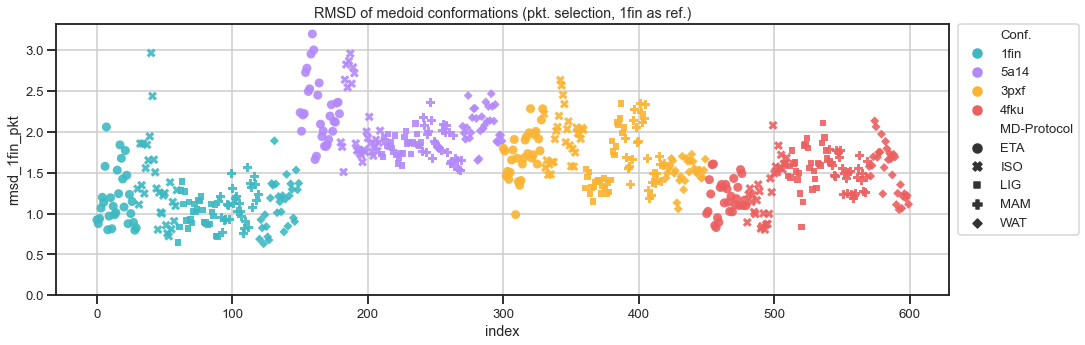

In [12]:
rmsd_pkt = pyt.rmsd(meds_traj, mask = mask_pkt_Ca, ref = ref_conf)
df_med['rmsd_1fin_pkt'] = rmsd_pkt 

fig, ax = plt.subplots(figsize = (16, 5))
sns.scatterplot(data = df_med.reset_index(), 
                x = 'index', y = 'rmsd_1fin_pkt',
                linewidth = 0, alpha = 0.9,
                palette = conf_label_colors,
                style = 'MD-Protocol',
                hue = 'Conf.')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title('RMSD of medoid conformations (pkt. selection, 1fin as ref.)')
plt.ylim(0)
plt.grid()
plt.show()

## RMSF of the MD represetative conformations ensemble

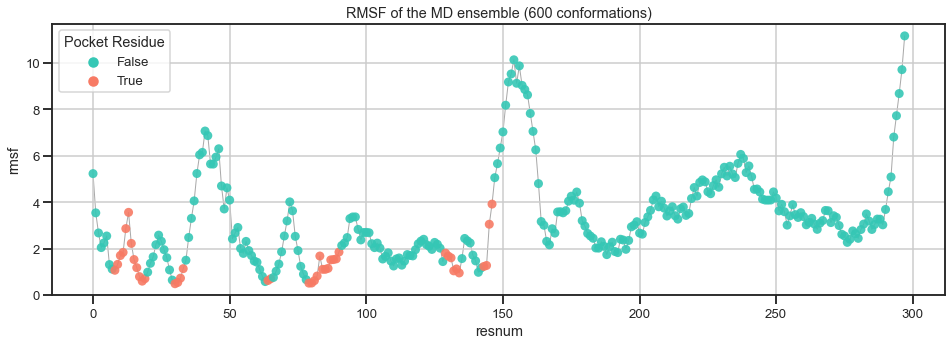

In [330]:
from helper_modules.protein_subsequences import get_secondary_structure_residues
def get_seq_mask(mask, length, max_val = 15):
    values = list(map(int, mask.split(' ')))
    full_mask = np.zeros(length, dtype=bool)
    full_mask[values] = True
    return full_mask

pkt_background = get_seq_mask(get_pocket_residues(), length = 298)

rmsf_Ca = pyt.rmsf(meds_traj, mask = '@CA')[:, 1]
df_rmsf = pd.DataFrame({
    'resnum': range(len(rmsf_Ca)),
    'rmsf': rmsf_Ca,
    'Pocket Residue': pkt_background
})

fig, ax = plt.subplots(figsize = (16, 5))
sns.lineplot(data = df_rmsf, x = 'resnum', y = 'rmsf',
                linewidth = 1, color = 'darkgrey', zorder=0)
sns.scatterplot(data = df_rmsf, x = 'resnum', y = 'rmsf',
                linewidth = 0, alpha = 0.9,
                hue = 'Pocket Residue', palette = ['#35C7B5', '#F77A64'])
plt.title(f'RMSF of the MD ensemble ({meds_traj.n_frames} conformations)')
plt.ylim(0)
plt.grid()
plt.show()

In [348]:
import nglview as nv
from nglview.color import ColormakerRegistry
from matplotlib import cm

colours = cm.rainbow((rmsf - np.min(rmsf)) / (np.max(rmsf) - np.min(rmsf))) * 255
rgb2hex = lambda r,g,b,a: '#%02x%02x%02x' %(int(r), int(g), int(b))

view = nv.show_pytraj(meds_traj)
color_scheme_list = [[rgb2hex(*c), str(i)] for i, c  in enumerate(colours)]
color_scheme = nv.color._ColorScheme(color_scheme_list, label="scheme_regions")
view.clear_representations()


cm = ColormakerRegistry
cm.add_selection_scheme("colRMSF",
        color_scheme_list)
rep = [
    {"type": "tube", "params": {
        "radiusType": 'data',
        "radiusData": (rmsf / 10)**1.1,
        "colorScheme": 'residueindex'
    }}
]

view.representations = rep
view.add_licorice(selection = ':' + get_pocket_residues())
view._remote_call('setSize', target='Widget', args=['','500px'])
view.camera='orthographic'
view

NGLWidget(max_frame=599)

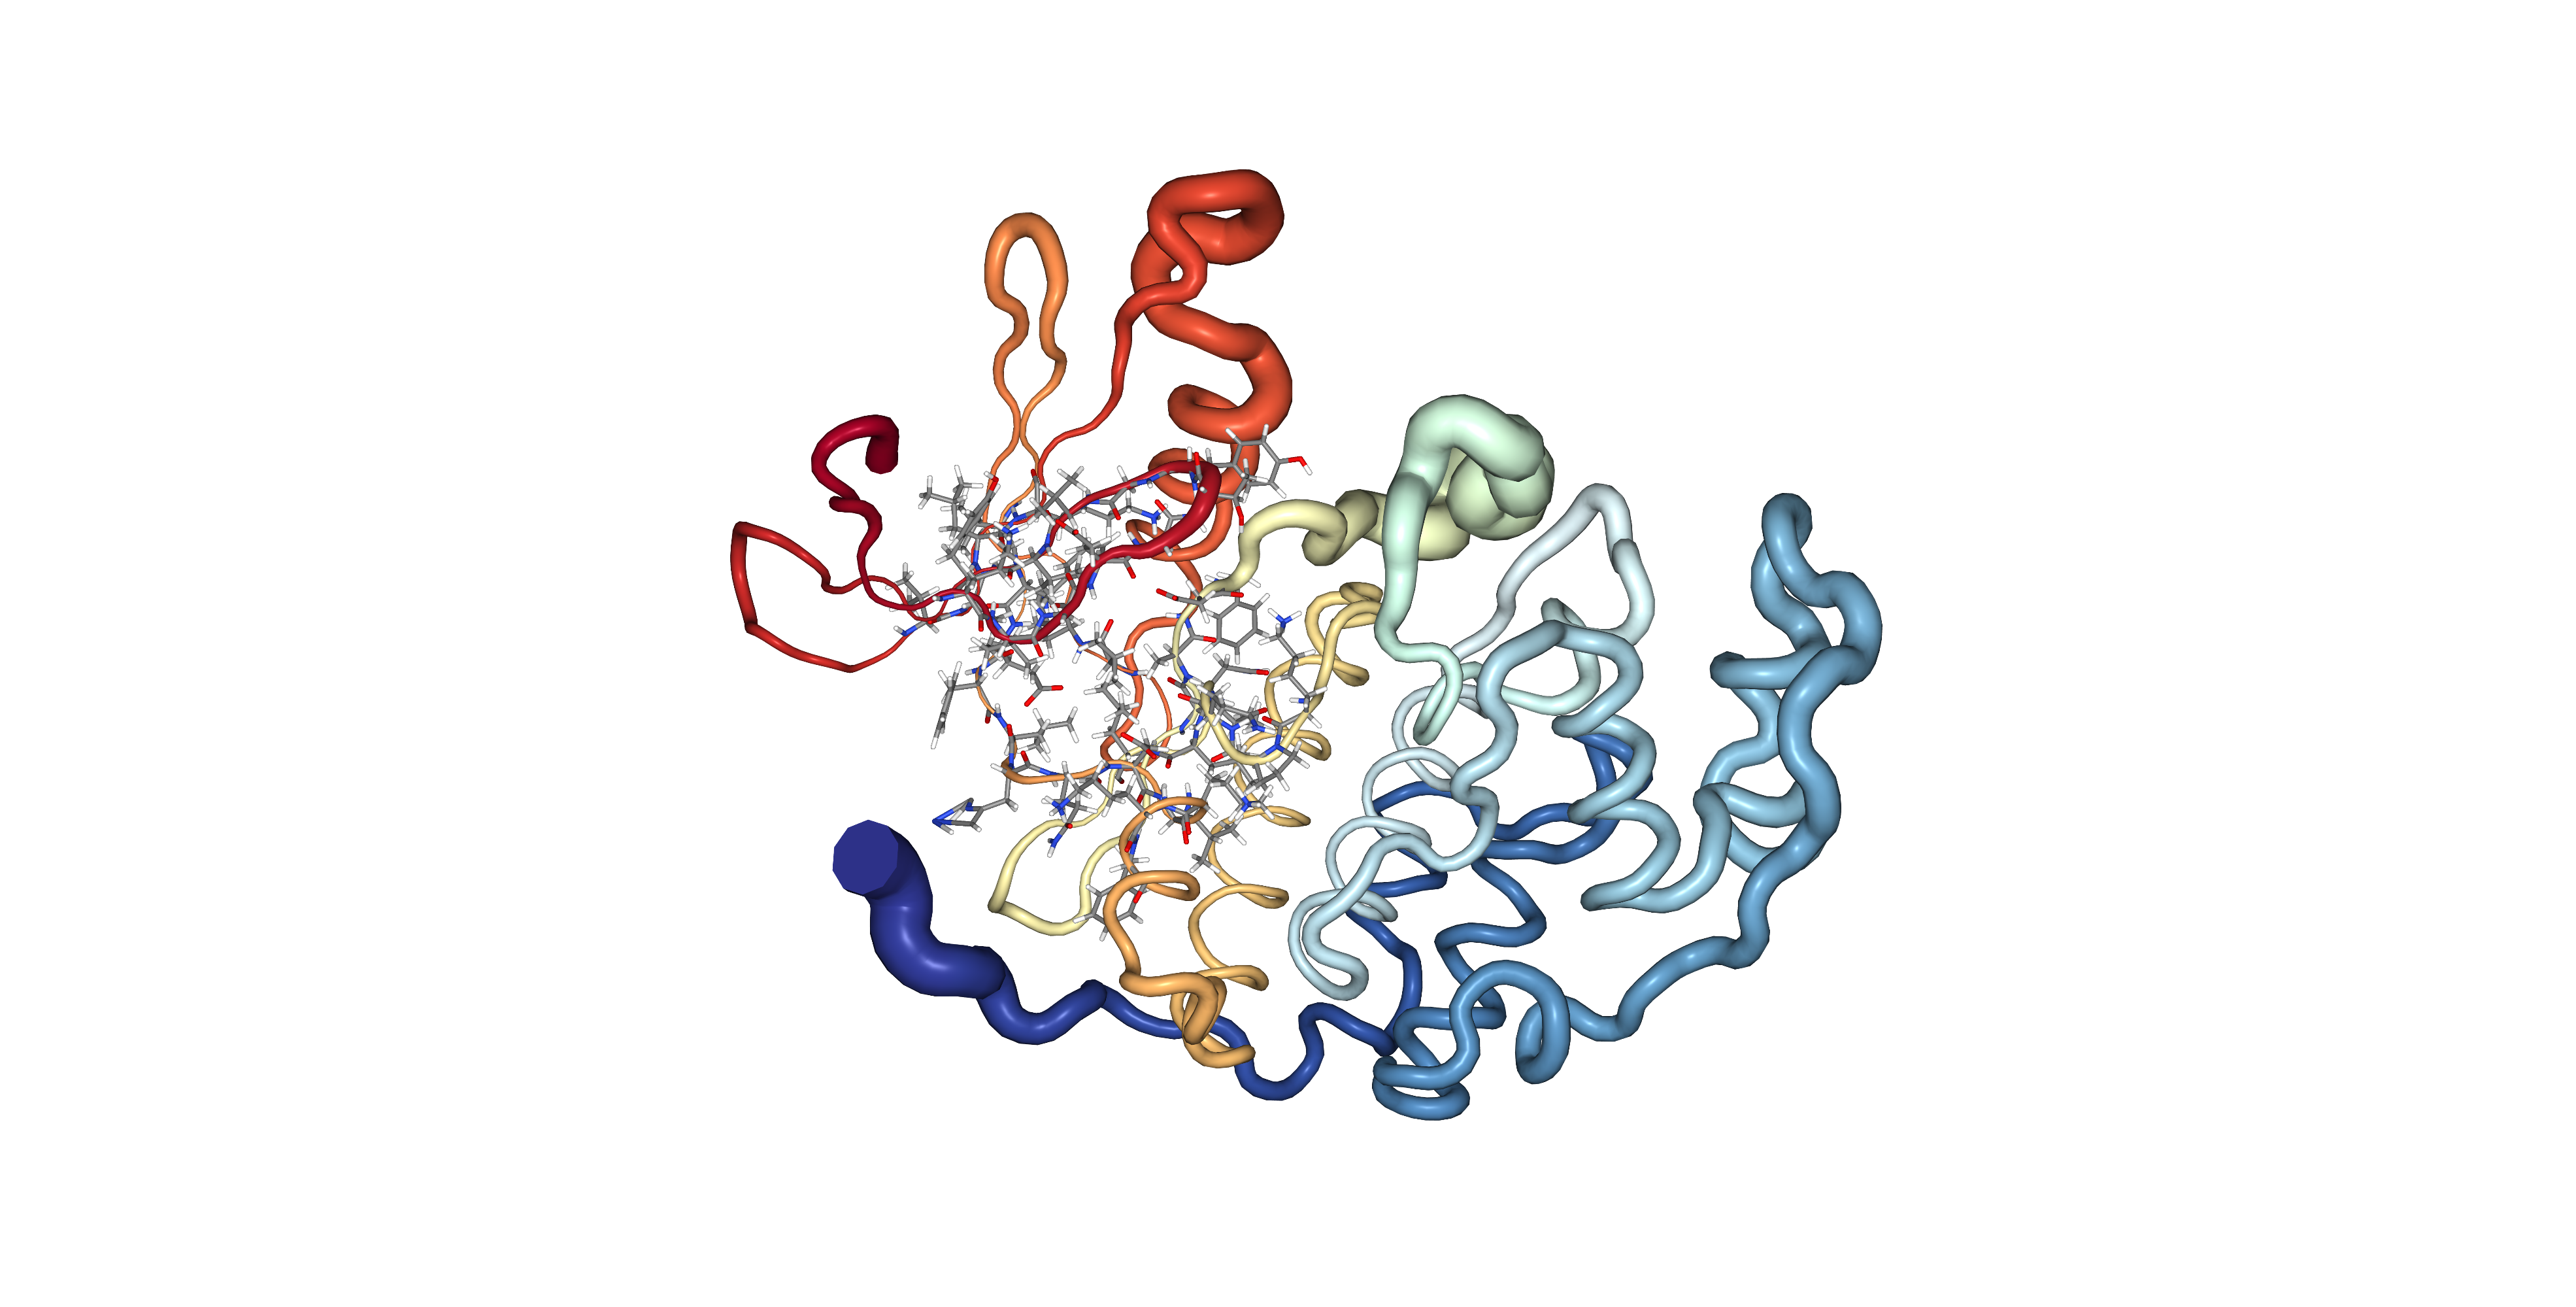

In [350]:
view.render_image()
view._display_image()

## Pairwise RMSD matrix

In [13]:
rmsd_mtx = pyt.pairwise_rmsd(meds_traj, mask = mask_pkt_Ca)

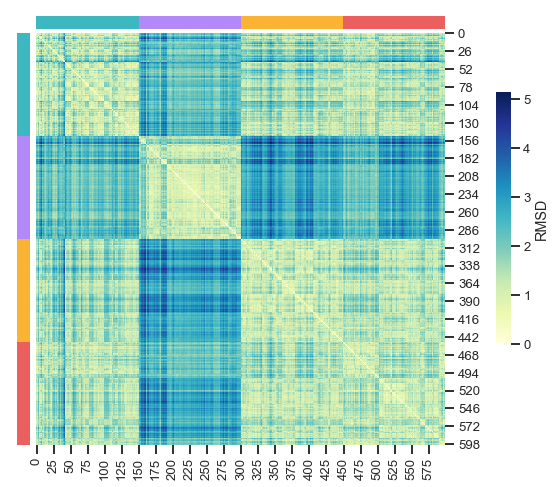

In [14]:
init_conf_cols = df_med['Conf.'].replace(conf_label_colors).to_numpy()
md_protocol_cols = df_med['MD-Protocol'].replace({'WAT': 'red', 'LIG': 'green',
                        'ETA': 'blue', 'ISO': 'orange', 
                        'MAM': 'violet'}).to_numpy()
sns.clustermap(rmsd_mtx, 
               cmap = 'YlGnBu',
                col_cluster = False, row_cluster = False,
                col_colors = init_conf_cols, 
                row_colors = init_conf_cols,
                cbar_pos = (1, 0.3, 0.03, 0.5), 
                dendrogram_ratio = (0.01, 0.01),
                cbar_kws={'label': 'RMSD'},
                figsize = (7, 7))

/Users/joelricci/miniconda/envs/biobb/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/joelricci/miniconda/envs/biobb/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


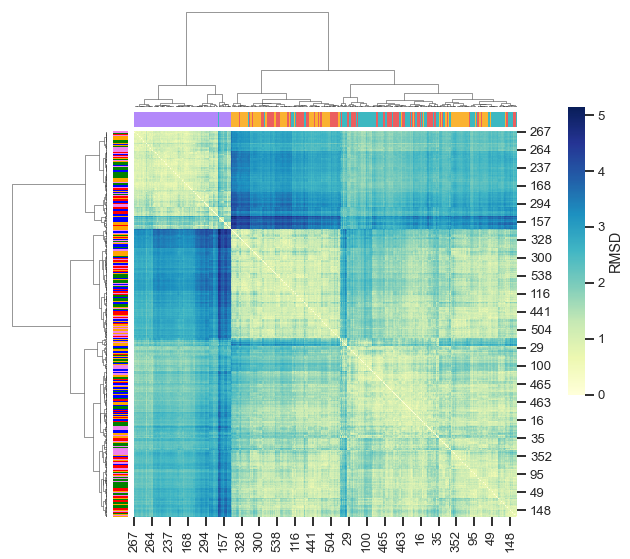

In [15]:
sns.clustermap(rmsd_mtx, 
               cmap = 'YlGnBu',
                col_cluster = True, row_cluster = True,
                method = 'ward',
                col_colors = init_conf_cols, 
                row_colors = md_protocol_cols,
                cbar_pos = (1, 0.3, 0.03, 0.5), 
                dendrogram_ratio = (0.2, 0.2),
                cbar_kws={'label': 'RMSD'},
                figsize = (8, 8))

## Classical Multidimensional Scaling

- Perform cMDS using the distance matrix (pairwise-RMSD) computed above.

In [16]:
from helper_modules.classical_MDS import cMDS

In [17]:
# Compute cMDS
cmds = cMDS(D = rmsd_mtx)
cmds_projs = cmds[0]
# Add the two first dimensions to the dataframe
df_med['cmds_x'] = cmds_projs[0]
df_med['cmds_y'] = cmds_projs[1]

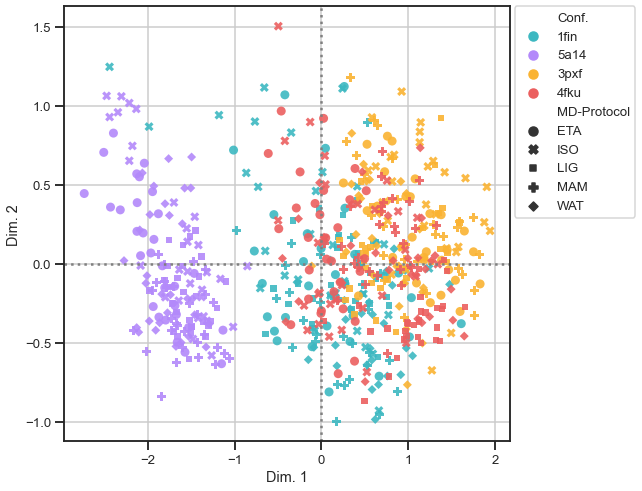

In [18]:
fig, ax = plt.subplots(figsize = (8, 8))
sns.scatterplot(data = df_med,
            x = 'cmds_x', y = 'cmds_y', 
            linewidth = 0, alpha = 0.9,
            palette = conf_label_colors,
            style = 'MD-Protocol',
            hue = 'Conf.'
           )
# ax.set_title(title)
ax.set(xlabel = 'Dim. 1', ylabel = 'Dim. 2')
ax.axvline(0, ls = ':', color = 'gray', lw = 2.5)
ax.axhline(0, ls = ':', color = 'gray', lw = 2.5)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
ax.grid()